In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import copy

# 1. Loading the Model

In [11]:
mnist = torchvision.datasets.MNIST(root='.', download=True, transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(10000)), 
                                           batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(10000, 15000)), 
                                          batch_size=1000, shuffle=True)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.model = nn.Sequential(
            # First Convolution Block
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 32 filters, 3x3 kernel, 'same' padding
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # 32 filters, 3x3 kernel, 'same' padding
            nn.BatchNorm2d(32),
            
            nn.MaxPool2d(2, 2),  # Max pooling (2x2) with stride 2
            nn.Dropout(0.25),

            # Second Convolution Block
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 64 filters, 3x3 kernel, 'same' padding
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # 64 filters, 3x3 kernel, 'same' padding
            nn.BatchNorm2d(64),

            nn.MaxPool2d(2, 2),  # Max pooling (2x2) with stride 2
            nn.Dropout(0.25),

            # Fully Connected (Dense) layers
            nn.Flatten(),
            
            nn.Linear(64 * 7 * 7, 512),  # Input size depends on the output of convolutional layers
            nn.BatchNorm1d(512),
            nn.Dropout(0.25),
            
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            
            nn.Linear(1024, 10)  # Output layer (10 classes)
        )
            
            

    def forward(self, x):
        x = self.model(x)
        return x

In [76]:
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f} | Accuracy: {100.*correct/total:.2f}%")

Epoch [1/10] Loss: 0.3190 | Accuracy: 90.30%
Epoch [2/10] Loss: 0.1625 | Accuracy: 94.96%
Epoch [3/10] Loss: 0.1239 | Accuracy: 96.27%
Epoch [4/10] Loss: 0.1270 | Accuracy: 96.24%
Epoch [5/10] Loss: 0.0980 | Accuracy: 97.10%
Epoch [6/10] Loss: 0.0951 | Accuracy: 97.26%
Epoch [7/10] Loss: 0.1018 | Accuracy: 96.76%
Epoch [8/10] Loss: 0.0760 | Accuracy: 97.46%
Epoch [9/10] Loss: 0.0651 | Accuracy: 97.94%
Epoch [10/10] Loss: 0.0699 | Accuracy: 97.85%


In [77]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100.*correct/total:.2f}%")

Test Accuracy: 97.62%


In [79]:
torch.save(model.state_dict(), 'cnn_weights/cnn_weights5.pth')

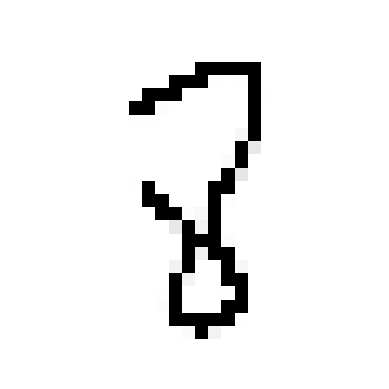

torch.Size([1, 1, 28, 28])
Predicted Class: 8


In [78]:
import torch
from torchvision import transforms
from PIL import Image

# Step 1: Load the image (example with a saved file)
img_path = '../sketch_stroke_digit_rnn/plots/image.png'  # Path to the saved 28x28 image
img = Image.open(img_path)

# Step 2: Preprocess the image
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure the image is in grayscale
    transforms.ToTensor(),  # Convert to PyTorch tensor (scales pixels to [0, 1])
])

img_tensor = transform(img).to(device)

img_tensor[img_tensor<0.9] = 0
img = img_tensor.squeeze(0).squeeze(0).cpu().numpy()  # Remove batch and channel dimensions

# Display the image using matplotlib
plt.imshow(img, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()




# Step 3: Add batch dimension (PyTorch models expect a batch of images)
img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension (1, 1, 28, 28)

# Step 4: Pass the tensor to the model
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():  # Turn off gradients since we're in inference mode
    print(img_tensor.size())
    output = model(img_tensor)  # Pass the image tensor to the model for prediction

# Step 5: Interpret the output
_, predicted_class = torch.max(output, 1)  # Get the predicted class index
print(f'Predicted Class: {predicted_class.item()}')